<a href="https://colab.research.google.com/github/wonkwonlee/a2w-kma-big-data-contest/blob/main/XGBoost_oversample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6lgsf5hCdduC9-ehpJzLnlGp9ZCeHSmWGOUQewCUVzAtkr805K1Us
Mounted at /content/drive


In [ ]:
# # 경로 설정 
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression


from xgboost import plot_importance
from xgboost import XGBClassifier

In [ ]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

# 데이터 처리 및 탐색

In [ ]:
raw_df = pd.read_csv("../A2W/데이터/data_submission/merge_final_real.csv", encoding='utf-8-sig')

In [ ]:
raw_df['1day_yn'] = 0.0
raw_df['2day_yn'] = 0.0

In [ ]:
# 열을 밀어서 출력, 맨 첫날, 마지막 날의 경우 산사태가 발생하지 않음.
raw_df['1day_yn'][1:-1] = raw_df['landslide'][0:-2]
raw_df['2day_yn'][2:-1] = raw_df['landslide'][0:-3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
select_df = raw_df[['maxTa','minTa','avgTa','EIGHT_AGL','stnId','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','1day_yn']]
cleaned_df_1 = select_df.fillna(0)
cleaned_df_1.info()
cleaned_df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093790 entries, 0 to 2093789
Data columns (total 34 columns):
 #   Column      Dtype  
---  ------      -----  
 0   maxTa       float64
 1   minTa       float64
 2   avgTa       float64
 3   EIGHT_AGL   float64
 4   stnId       int64  
 5   mi10MaxRn   float64
 6   hr1MaxRn    float64
 7   sumRnDur    float64
 8   sumRn       float64
 9   maxInsWs    float64
 10  maxWs       float64
 11  avgWs       float64
 12  minRhm      float64
 13  avgRhm      float64
 14  n99Rn       float64
 15  PRRCK_LARG  int64  
 16  PRRCK_MDDL  int64  
 17  LOCTN_ALTT  float64
 18  LOCTN_GRDN  float64
 19  CLZN_CD     int64  
 20  TPGRP_TPCD  int64  
 21  PRDN_FOM_C  int64  
 22  SLDPT_TPCD  int64  
 23  SLANT_TYP   int64  
 24  SCSTX_CD    int64  
 25  SLTP_CD     int64  
 26  STORUNST    float64
 27  FROR_CD     float64
 28  FRTP_CD     float64
 29  KOFTR_GROU  float64
 30  DMCLS_CD    float64
 31  AGCLS_CD    float64
 32  HEIGHT      float64
 33  1day_yn

,maxTa,minTa,avgTa,EIGHT_AGL,stnId,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLDPT_TPCD,SLANT_TYP,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT,1day_yn
0,2.1,-1.1,0.8,0.0,115,0.0,0.0,19.33,28.0,29.4,19.0,11.1,65.0,82.5,5.8,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
1,1.3,-0.9,0.1,0.0,115,0.0,0.0,22.83,24.8,14.5,8.5,6.0,65.0,91.5,29.7,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
2,0.8,-1.4,-0.3,0.0,115,0.0,0.0,12.83,7.5,15.9,10.2,6.5,61.0,80.3,0.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
3,3.9,0.4,1.7,0.0,115,0.0,0.0,0.00,0.0,11.2,6.8,3.1,53.0,63.1,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0
4,2.6,-1.2,1.2,0.0,115,0.0,0.0,7.25,1.8,13.9,6.9,4.1,42.0,61.5,12.3,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,1.0,5.0,16.0,0.0


## 1일 후 예측

In [ ]:
y = cleaned_df_1['1day_yn']
X = cleaned_df_1.drop('1day_yn', axis =1)

In [ ]:
X.value_counts()
y.value_counts()

0.0    2093431
1.0        359
Name: 1day_yn, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# 1: 50 비율
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 17950}).fit_sample(X, y)
X_df = pd.DataFrame(X_samp)
y_df = pd.DataFrame(y_samp)

df_samp = pd.concat([X_df, y_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
X_samp, y_samp = RandomOverSampler(random_state=1024, sampling_strategy='minority').fit_sample(X, y)
X_df = pd.DataFrame(X_samp)
y_df = pd.DataFrame(y_samp)

df_samp = pd.concat([X_df, y_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_df.value_counts()

1.0    2093431
0.0    2093431
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, shuffle=True, stratify=y_df, random_state=1024)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3140146, 33)
X_test shape: (1046716, 33)
y_train shape: (3140146, 1)
y_test shape: (1046716, 1)


In [ ]:
xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
metrics(y_test, xgb_pred)

### 하이퍼 파라미터 튜닝 후 예측

In [ ]:
xgb = XGBClassifier()

xgb_param_grid = {
    'n_estimators' : [100, 200, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}
# sklearn.metrics.SCORERS.keys()
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="roc_auc", n_jobs= 1, verbose = 1)
xgb_grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  [0],
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  "zero pos_label and zero neg_label, got "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  [0],
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  "zero pos_la

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 2

In [ ]:
print("최고 평균 auc : {0:.4f}".format(xgb_grid.best_score_))
print("최고의 파라미터 : ", xgb_grid.best_params_)

최고 평균 auc : 0.9906
최고의 파라미터 :  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
result = pd.DataFrame(xgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)

In [ ]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
84,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti...",0.990617,1
34,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.990372,2
37,"{'learning_rate': 0.05, 'max_depth': 12, 'n_es...",0.990105,3
35,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.990083,4
56,"{'learning_rate': 0.1, 'max_depth': 12, 'n_est...",0.990072,5
64,"{'learning_rate': 0.15, 'max_depth': 6, 'n_est...",0.990072,6
85,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti...",0.990053,7
33,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.990030,8
53,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.989992,9
68,"{'learning_rate': 0.15, 'max_depth': 8, 'n_est...",0.989915,10


## 최고의 파라미터 값으로 예측 실시 
n_estimators = 100, learning_rate = 0.2, max_depth = 6

In [ ]:
xgb = XGBClassifier(n_estimators=100, learning_rate = 0.2, max_depth = 6)
evals = [(X_test, y_test)]
xgb.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 1)

[0]	validation_0-logloss:0.524379
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.409751
[2]	validation_0-logloss:0.327662
[3]	validation_0-logloss:0.266058
[4]	validation_0-logloss:0.220372
[5]	validation_0-logloss:0.184645


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  [0],
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  "zero pos_label and zero neg_label, got "


[6]	validation_0-logloss:0.156692
[7]	validation_0-logloss:0.133744
[8]	validation_0-logloss:0.116104
[9]	validation_0-logloss:0.101512
[10]	validation_0-logloss:0.089465
[11]	validation_0-logloss:0.080623
[12]	validation_0-logloss:0.073107
[13]	validation_0-logloss:0.067155
[14]	validation_0-logloss:0.062196
[15]	validation_0-logloss:0.057276
[16]	validation_0-logloss:0.053099
[17]	validation_0-logloss:0.050062
[18]	validation_0-logloss:0.04775
[19]	validation_0-logloss:0.046143
[20]	validation_0-logloss:0.044494
[21]	validation_0-logloss:0.041737
[22]	validation_0-logloss:0.040874
[23]	validation_0-logloss:0.039766
[24]	validation_0-logloss:0.037527
[25]	validation_0-logloss:0.036514
[26]	validation_0-logloss:0.035013
[27]	validation_0-logloss:0.034544
[28]	validation_0-logloss:0.033735
[29]	validation_0-logloss:0.033104
[30]	validation_0-logloss:0.032895
[31]	validation_0-logloss:0.032659
[32]	validation_0-logloss:0.032441
[33]	validation_0-logloss:0.032097
[34]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred = xgb.predict(X_test)
metrics(y_test, xgb_pred)

정확도 : 0.99, 정밀도 : 0.96, 재현율 : 0.78
f1-score : 0.86, auc : 0.89


## 2일 후 예측

In [ ]:
#분석을 위해 음수 값을 가지는 칼럼들을 제외하고 결측치를 0으로 대체한다.
select_df = raw_df[['maxTa','minTa','avgTa','EIGHT_AGL','stnId','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','2day_yn']]
cleaned_df_2 = select_df.fillna(0)

In [ ]:
y = cleaned_df_2['2day_yn']
X = cleaned_df_2.drop('2day_yn', axis =1)

In [ ]:
# 1: 50 비율
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 17950}).fit_sample(X, y)
X_df = pd.DataFrame(X_samp)
y_df = pd.DataFrame(y_samp)

df_samp = pd.concat([X_df, y_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, shuffle=True, stratify=y_df, random_state=1024)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (13731, 33)
X_test shape: (4578, 33)
y_train shape: (13731, 1)
y_test shape: (4578, 1)


In [ ]:
# 최고 하이퍼 파라미터 값으로 예측 실시
xgb = XGBClassifier(n_estimators=100, learning_rate = 0.2, max_depth = 6)
evals = [(X_test, y_test)]
xgb.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 1)

[0]	validation_0-logloss:0.523628
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.409944
[2]	validation_0-logloss:0.328209
[3]	validation_0-logloss:0.266016
[4]	validation_0-logloss:0.219081


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  [0],
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  "zero pos_label and zero neg_label, got "


[5]	validation_0-logloss:0.183136
[6]	validation_0-logloss:0.15394
[7]	validation_0-logloss:0.131121
[8]	validation_0-logloss:0.113175
[9]	validation_0-logloss:0.099038
[10]	validation_0-logloss:0.087109
[11]	validation_0-logloss:0.077889
[12]	validation_0-logloss:0.070422
[13]	validation_0-logloss:0.064108
[14]	validation_0-logloss:0.057349
[15]	validation_0-logloss:0.053129
[16]	validation_0-logloss:0.049165
[17]	validation_0-logloss:0.046038
[18]	validation_0-logloss:0.043482
[19]	validation_0-logloss:0.041793
[20]	validation_0-logloss:0.039151
[21]	validation_0-logloss:0.037914
[22]	validation_0-logloss:0.036951
[23]	validation_0-logloss:0.035638
[24]	validation_0-logloss:0.034986
[25]	validation_0-logloss:0.034363
[26]	validation_0-logloss:0.033371
[27]	validation_0-logloss:0.032889
[28]	validation_0-logloss:0.031726
[29]	validation_0-logloss:0.031368
[30]	validation_0-logloss:0.030108
[31]	validation_0-logloss:0.030153
[32]	validation_0-logloss:0.029432
[33]	validation_0-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred = xgb.predict(X_test)
metrics(y_test, xgb_pred)

정확도 : 0.99, 정밀도 : 0.93, 재현율 : 0.76
f1-score : 0.83, auc : 0.88


# XGBoost 결과
## 하이퍼 파라미터
* n_estimators = 100
* learning_rate = 0.2
* max_depth = 6

## 1일 뒤 예측
* 정확도: 0.99
* 정밀도: 0.96
* 재현율: 0.79
* f1-score: 0.86
* AUC: 0.89

## 2일 뒤 예측
* 정확도: 0.99
* 정밀도: 0.93
* 재현율: 0.76
* f1-score: 0.83
* AUC: 0.88

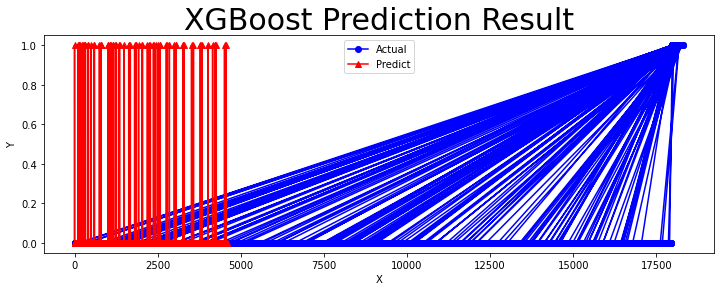

In [ ]:
# XGBoost 모델 시각화: 실제값과 예측값 비교
fig = plt.figure(figsize = (12, 4))
chart = fig.add_subplot(1,1,1)
chart.plot(y_test, marker='o', color='blue', label='Actual')
chart.plot(xgb_pred, marker='^', color='red', label='Predict')
chart.set_title('XGBoost Prediction Result', size=30)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc = 'best') 